In [1532]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
from functools import wraps
import os
import random
from abc import ABC, abstractmethod
from collections import deque, namedtuple
import scipy.integrate as integrate
import scipy.optimize as optimize
T.Tensor.ndim = property(lambda self: len(self.shape))

In [1533]:
@dataclass
class EnforceClassTyping:
    def __post_init__(self):
        for (name, field_type) in self.__annotations__.items():
            if not isinstance(self.__dict__[name], field_type):
                current_type = type(self.__dict__[name])
                raise TypeError(f"The field `{name}` was assigned by `{current_type}` instead of `{field_type}`")
        # print("Check is passed successfully")
def EnforceMethodTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for class mathods'
    arg_annotations = func.__annotations__
    if not arg_annotations:
        return func

    @wraps(func)
    def wrapper(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> Any:
        for arg, annotation in zip(args, arg_annotations.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for argument {arg}, got {type(arg)}.")

        for arg_name, arg_value in kwargs.items():
            if arg_name in arg_annotations:
                annotation = arg_annotations[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for keyword argument {arg_name}, got {type(arg_value)}.")

        return func(self, *args, **kwargs)

    return wrapper
def EnforceFunctionTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for other functions'
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Check positional arguments
        for arg, annotation in zip(args, func.__annotations__.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for {arg}, got {type(arg)}.")

        # Check keyword arguments
        for arg_name, arg_value in kwargs.items():
            if arg_name in func.__annotations__:
                annotation = func.__annotations__[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for {arg_name}, got {type(arg_value)}.")

        return func(*args, **kwargs)

    return wrapper


**Ornstein Uhlenbeck Noise**

In [1534]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)
 

**Particle**

In [1535]:
@dataclass
class Particle(EnforceClassTyping):
    'This class represents the electric field sources with its position in the field(Position) and the magnitude of the source(Charge)'
    Mass: float # kg
    Charge: float #C


**Particle Test**

In [1536]:
NegativeCharge= Particle(Mass=1.0, Charge= -1e-5)
PositiveCharge= Particle(Mass=10.0, Charge= 1e-5)
Sources = {"Particle": [NegativeCharge],
          "Position": [T.tensor([1.0, 1.0])]}

**Vector Field**

In [1537]:
from torch import Tensor

@dataclass
class Field(ABC):
  @abstractmethod
  def FieldStrength(self, ObservationPosition: T.Tensor)-> T.Tensor:
    ...
  @abstractmethod
  def FieldPotential(self, ObservationPosition: T.Tensor)-> float:
    ...
  def PotentialDifference(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor) -> float:
    ...

@dataclass(kw_only= True)
class ElectricField(Field):
  FieldSources: Dict

  def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
      return self.FieldStrength(ObservationPosition)
  @EnforceMethodTyping
  def FieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
    'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**2
    return CoulombConstant * ElectricFieldVector #N/C or V/m
  @EnforceMethodTyping
  def FieldPotential(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
      '''This method determines the amount of work required to get one position to another in the field'''
      XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
      YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
      XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
      YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
      WorkDone = 0
      for i in range(resolution):
          PositionFieldStrength = self.FieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
          WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
      return WorkDone
  @EnforceMethodTyping
  def PlotField(self):
      'This funtion plots the 2D electric vector field'
      ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 50), 
                                      T.linspace(self.FieldLowBound, self.FieldHighBound, 50))
      ObservationPosition= T.stack(ObservationPosition)
      xd, yd = self.ElectricFieldStrength(ObservationPosition)
      xd = xd / T.sqrt(xd**2 + yd**2)
      yd = yd / T.sqrt(xd**2 + yd**2)
      color_aara = T.sqrt(xd**2+ yd**2)
      fig, ax = plt.subplots(1,1)
      cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
      fig.colorbar(cp)
      plt.rcParams['figure.dpi'] = 250
      plt.show()
  def Derivative(self, ObservationPosition):
    'This function returns the derivative of the field at a given point'
    CoulombConstant = 8.9875e9 #N*m^2/C^2
    assert len(self.FieldSources["Particle"]) == len(self.FieldSources["Position"]), "The length of particles and fields don't match"
    for FieldSource, _ in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      assert isinstance(FieldSource, Particle),  "The FieldSource is not a Particle"
    ElectricFieldVector = T.zeros_like(ObservationPosition)
    for FieldSource, SourcePosition in zip(self.FieldSources["Particle"], self.FieldSources["Position"]):
      PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* SourcePosition[0].item(), 
                                T.ones_like(ObservationPosition[1])* SourcePosition[1].item()])
      DisplacementVector = ObservationPosition - PositionMatrices
      DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
      ElectricFieldVector += (DisplacementVector * FieldSource.Charge) / DisplacementMagnitude**1.5
    return -CoulombConstant * ElectricFieldVector

**Vector Field Test**

In [1538]:

TestElectricField= ElectricField(FieldSources=Sources)


In [1539]:
class HomogenousField(Field):
    def FieldStrength(self, ObservationPosition: T.Tensor)-> T.Tensor:
        return  T.zeros((ObservationPosition.shape[0], self.Dimensions), dtype=T.float64)
    def FieldPotential(self, ObservationPosition: T.Tensor)-> float:
        return  0.0

@dataclass(kw_only= True)
class LJField(Field):
    FieldSources: list[Particle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
        return self.FieldStrength(ObservationPosition)
    @EnforceMethodTyping
    def FieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != Particle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == T.Tensor, "Invalid Reference point data type"
        ElectricFieldVector = T.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            T.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += ((FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector) - ((FieldSource.Charge) / DisplacementMagnitude**6 * DisplacementVector)
        ElectricFieldVector= CoulombConstant *ElectricFieldVector
        return ElectricFieldVector #N/C or V/m
    @EnforceMethodTyping
    def FieldPotential(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ForceFieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @EnforceMethodTyping
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 40), 
                                        T.linspace(self.FieldLowBound, self.FieldHighBound, 40))
        ObservationPosition= T.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / T.sqrt(xd**2 + yd**2)
        yd = yd / T.sqrt(xd**2 + yd**2)
        color_aara = T.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()


In [1540]:
# should obey newtons laws in Homogenous vector field 
@dataclass(kw_only=True)
class Environment(ABC):  

  class State:
      pass
  InitialState: State 
  CurrentState: State 

  @abstractmethod
  def TransitionModel(self, State: State, Action)-> State:
      ...

  @abstractmethod
  def RewardModel(self, State: State, Action, NextState: State, TerminalSignal: bool)-> float:
      '''This is a scalar performance metric.'''
      ...

  @abstractmethod
  def IsTerminalCondition(self, State: State)-> bool:
      ...

  @abstractmethod
  def StateTransition(self, State: State, Action)-> tuple[float, State, bool]:
      ...

  @abstractmethod
  def SampleTrajectory(self, RunDuration: float)-> list[State]:
      ...
  @abstractmethod
  def TrajectoryValue(self, Trajectory: list[State])-> float:
      ...
  @abstractmethod
  def Reset(self):
      ...

**Environment**

In [1541]:
@dataclass(kw_only=True)
class ParticleInField(Environment): 
  Field: Field
  ChargedParticle: Particle
  Target: T.Tensor
  DistanceWeight: float= 1.0
  EnergyWeight: float= -1.0
  TerminalSignalWeight: float= -1000.0
  CurrentTime: float = 0.0# s
  @dataclass 
  class State(EnforceClassTyping):
    '''This class represents the state of the Agent with its Position, Velocity and the Field Strength if experiences at its Position. 
    These are parameters the agent is able to observe, they uniquely define the state of the agent.'''
    Position: T.Tensor # m
    Velocity: T.Tensor #kg*m/s
    
    def Vector(self):
      return T.cat([self.Position, self.Velocity])
  InitialState: State = None
  CurrentState: State = None
  def __post_init__(self):
    if self.InitialState is None:
        self.InitialState= self.RandomState()
    self.CurrentState= self.InitialState

  def StateDynamics(self, State: T.Tensor, Time: float, ControlForce: T.Tensor):
    dxPosition, dyPosition = State[2], State[3]
    Position= T.tensor([State[0], State[1]])
    dxVelocity, dyVelocity = ((self.ChargedParticle.Charge* self.Field(Position))+ControlForce)/self.ChargedParticle.Mass

    return np.array([dxPosition, dyPosition, dxVelocity, dyVelocity])
  
  @EnforceMethodTyping
  def TransitionModel(self, State: State, Action: T.Tensor= T.tensor([0.0, 0.0]), TimeInterval:float= 1.0)-> State:
    '''Outputs the state of the system after taking an action(applying a constant force for *TimeInterval* seconds)'''
    Posx, Posy, Velx, Vely= integrate.odeint(self.StateDynamics, State.Vector(), [self.CurrentTime, self.CurrentTime+ TimeInterval], args=(Action,))[-1]
    CurrrentPosition= T.tensor([Posx, Posy])
    CurrentVelocity= T.tensor([Velx, Vely])
    return self.State(CurrrentPosition, CurrentVelocity)
  
  def RewardModel(self, State: State, Action: T.Tensor, NextState: State, TerminalSignal: bool)-> float:
      '''This method determines how the agent is rewarded given a state transition. The reward determines the behaviour the agent should learn(i.e getting to the target and using the least amount of energy).'''
      DistanceGainedFromTarget= T.norm(State.Position-self.Target)- T.norm(NextState.Position-self.Target) 
      EnergyConsumed= self.ChargedParticle.Charge* self.Field.FieldPotential(State.Position, NextState.Position)
      Cost= self.DistanceWeight* DistanceGainedFromTarget+ self.EnergyWeight* EnergyConsumed+ self.TerminalSignalWeight* TerminalSignal
      return Cost.item()
  
  @EnforceMethodTyping
  def IsTerminalCondition(self, State: State)-> bool:
      '''This method determines if the state is within the viable learning region of the environment: Constraints'''
      WithinXBound= -10. <= State.Position[0] <= 10.
      WithinYBound= -10. <= State.Position[1] <= 10. 
      WithinVelocityBound= T.norm(State.Velocity) < 10. 
      if WithinXBound and WithinYBound and WithinVelocityBound: 
          return False    
      else:
          return True
  
  def StateTransition(self, State: State= CurrentState, Action: T.Tensor= T.tensor([0.0, 0.0]), TimeInterval: float= 1.0):
      'Outputs the state of the system after taking an action, the reward ocurring from the transition and the terminal signal'
      NextState= self.TransitionModel(State, Action, TimeInterval=TimeInterval)
      TerminalSignal= self.IsTerminalCondition(NextState) 
      Reward= self.RewardModel(State, Action, NextState, TerminalSignal)
      return NextState, Reward, TerminalSignal
  
  @EnforceMethodTyping
  def RandomState(self)->State:
      '''This method generates a random state within the viable learning region'''
      RandomPosition= T.tensor([np.random.uniform(-10., 10.), 
                                np.random.uniform(-10., 10.)])
      RandomVelocity= T.zeros_like(RandomPosition)
      return self.State(RandomPosition, RandomVelocity)

  def SampleTrajectory(self, RunDuration: float, Policy: Optional[Callable]= None, TimeStep: int=0.1):
    Time= [0]
    State= self.CurrentState
    StateTrajectory= []
    ActionTrajectory= []
    while Time[-1]<RunDuration: 
      StateTrajectory.append(State)
      if Policy is Callable:
        Action = Policy(State)
      else:
          Action = T.randn(2)
      ActionTrajectory.append(Action)
      State= self.TransitionModel(State, Action, TimeInterval= TimeStep) 
      Time.append(Time[-1]+TimeStep) 
    return StateTrajectory, ActionTrajectory, Time

  def PlotTrajectory(self, StateTrajectory, Time): 
      PositionPath= [State.Position for State in StateTrajectory]
      VelocityPath= [State.Velocity for State in StateTrajectory]
      PositionTrajectory= T.stack(PositionPath).transpose(dim0=0, dim1=1)
      VelocityTrajectory= T.stack(VelocityPath).transpose(dim0=0, dim1=1)
      plt.plot(PositionTrajectory[0], PositionTrajectory[1])
      plt.plot(PositionTrajectory[0][0], PositionTrajectory[1][0], 'ko')
      plt.plot(PositionTrajectory[0][-1], PositionTrajectory[1][-1], 'r*')
      plt.xlim(-10,10)
      plt.ylim(-10,10)
      plt.grid(True)
      plt.show()

  def TrajectoryValue(self, StateTrajectory: list[State], ActionTrajectory, Time)-> float:
      Value= 0
      TimeInterval= (Time[-1]-Time[0])/len(Time)
      for State, Action in zip(StateTrajectory, ActionTrajectory):
         Value= Value+ (T.norm(State.Position-self.Target)+T.norm(Action))* TimeInterval
      return Value
  
  def Reset(self):
      self.CurrentState= self.InitialState
      self.CurrentTime= 0.0


**Environment Test**

In [1542]:
PositiveChargeInElectricField= ParticleInField(Field=TestElectricField, ChargedParticle=PositiveCharge, Target=T.tensor([0.0, 0.0]))


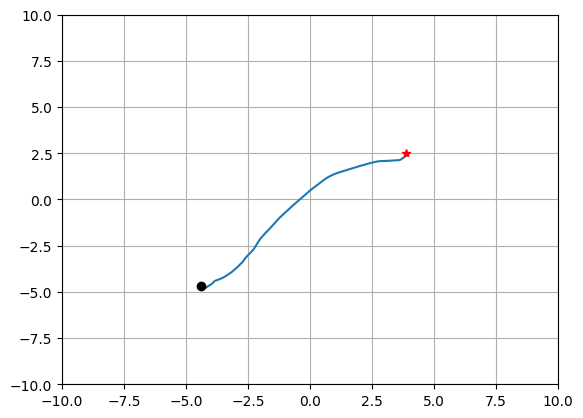

tensor(272.7470, dtype=torch.float64)

In [1543]:
StateTrajectory, ActionTrajectory, Time= PositiveChargeInElectricField.SampleTrajectory(50)
Return= PositiveChargeInElectricField.TrajectoryValue(StateTrajectory, ActionTrajectory, Time)
PositiveChargeInElectricField.PlotTrajectory(StateTrajectory, Time)
Return


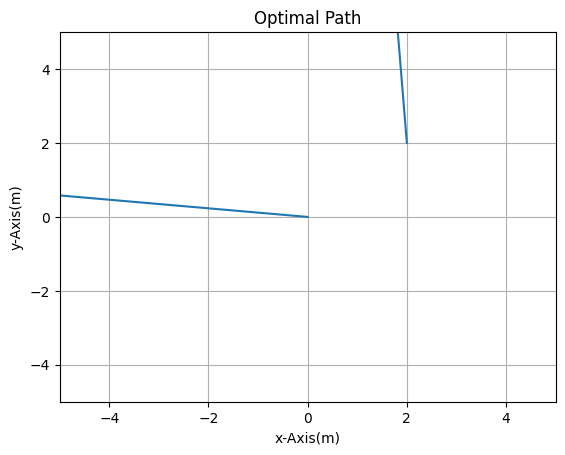

In [1544]:
N = 50    # number of time steps
t_f = 5.0  # final time (s)
dt = t_f / (N - 1)
x_final= np.array([2.0, 0.0, 2.0, 0.0])
x_initial= np.array([0.0, 0.0, 0.0, 0.0])

def dynamics(State, _, ControlForce):
  dxPosition, dyPosition = State[1], State[3]
  Position= T.tensor([State[0], State[2]])
  dxVelocity, dyVelocity = ((PositiveCharge.Charge* TestElectricField(Position))+ControlForce)/PositiveCharge.Mass

  return np.array([dxPosition, dxVelocity, dyPosition, dyVelocity])

def objective(z):
    px, _, py, _, ux, uy = z.reshape(6, N)
    Pos= T.transpose(T.cat([T.tensor([px]), T.tensor([py])], 0), 0, 1)
    EField= [T.norm(TestElectricField(i)) for i in Pos]
    return sum(EField)

def DynamicsConstraint(z):
  px, vx, py, vy, ux, uy = z.reshape(6, N)
  x= np.vstack((px, vx, py, vy)).transpose()
  u= np.vstack((ux, uy)).transpose()
  ceq = []

  for k in range(N-1):
    f_k = dynamics(x[k], 1.0, u[k])
    f_kp1 = dynamics(x[k+1], 1.0, u[k+1])
    ceq.append((x[k+1] - x[k]) - (dt * (f_k + f_kp1))/2)
  return np.array(ceq).transpose().flatten()

def BoundaryConstraint(z):
  px, vx, py, vy, _, _ = z.reshape(6, N)
  xi= np.vstack((px, vx, py, vy)).transpose()[0]
  xf= np.vstack((px, vx, py, vy)).transpose()[-1]
  x= np.concatenate((xi, xf), axis=None)
  x_bounds= np.concatenate((x_initial, x_final), axis=None)
  return x-x_bounds

InitialGuess = np.zeros(6*N)
InitialGuess[:N] = np.linspace(x_initial[0], x_final[0], N)  # xPosition Initial Guess
InitialGuess[N:2*N] = np.linspace(x_initial[0], x_final[1], N)  # xVelocity Initial Guess
InitialGuess[2*N:3*N] = np.linspace(x_initial[0], x_final[2], N)  # yPosition Initial Guess
InitialGuess[3*N:4*N] = np.linspace(x_initial[0], x_final[3], N)  # yVelocity Initial Guess

res = optimize.minimize(objective, InitialGuess, method='SLSQP', constraints=({'type': 'eq', 'fun': DynamicsConstraint}, 
                                                                              {'type': 'eq', 'fun': BoundaryConstraint}))

t = np.linspace(0, t_f, N)
px, vx, py, vy, ux, uy = res.x.reshape(6, N)
plt.plot(px, py)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.grid(True)
plt.title('Optimal Path')
plt.xlabel('x-Axis(m)')
plt.ylabel('y-Axis(m)')
plt.show()
